In [ ]:
!pip install swig
!pip3 install box2d-py
!pip3 install gym[Box_2D]
!pip3 install gym stable-baselines3[extra] shimmy sb3-contrib

In [2]:
import gym
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import base64, io

import numpy as np
from collections import deque, namedtuple

# For visualization
from gym.wrappers.monitoring import video_recorder
from IPython.display import HTML
from IPython import display
import glob

import pandas as pd

In [3]:
env = gym.make('LunarLander-v2')
env.seed(0)
print('State shape: ', env.observation_space.shape)
print('Number of actions: ', env.action_space.n)

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<frozen importlib._bootstrap>:241: DeprecationWarning: builtin type SwigPyPacked has no __module__ attribute
<frozen importlib._bootstrap>:241: DeprecationWarning: builtin type SwigPyObject has no __module__ attribute
<frozen importlib._bootstrap>:241: DeprecationWarning: builtin type swigvarlink has no __module__ attribute
/usr/local/lib/python3.11/dist-packages/pygame/pkgdata.py:25: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import resource_stream, resource_exists


State shape:  (8,)
Number of actions:  4


/usr/local/lib/python3.11/dist-packages/pkg_resources/__init__.py:3154: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  declare_namespace(pkg)
/usr/local/lib/python3.11/dist-packages/pkg_resources/__init__.py:3154: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google.cloud')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  declare_namespace(pkg)
/usr/local/lib/python3.11/dist-packages/pkg_resources/__init__.py:3154: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('sphinxcontrib')`.
Implementing implicit namespace packages (as sp

### Random agent performance

In [35]:
max_episodes = 500

scores_random = []
actions = range(env.action_space.n)
for i in range(1, max_episodes+1):
    state = env.reset()
    score = 0
    while True:
        action = np.random.choice(actions)
        state, reward, done, info = env.step(action)
        score += reward
        if done:
            break

    scores_random.append(score)

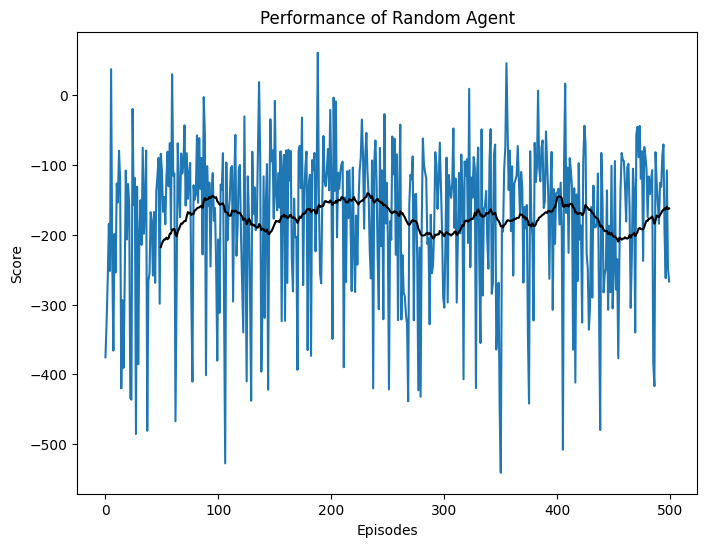

In [36]:
plt.figure(figsize=(8,6))
plt.plot(scores_random)
plt.plot(pd.Series(scores_random).rolling(50).mean(), color='black')
plt.title('Performance of Random Agent')
plt.xlabel('Episodes')
plt.ylabel('Score')
plt.show()

### Network Architecture

In [6]:
class QNetwork(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, state_size, action_size, seed):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
        """
        super(QNetwork, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, action_size)

    def forward(self, state):
        """Build a network that maps state -> action values."""
        x = self.fc1(state)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        return self.fc3(x)

### Hyperparameters

In [7]:
BUFFER_SIZE = int(1e5)  # replay buffer size
BATCH_SIZE = 64         # minibatch size
GAMMA = 0.99            # discount factor
TAU = 1e-3              # for soft update of target parameters
LR = 5e-4               # learning rate
UPDATE_EVERY = 4        # how often to update the network

In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Define Agent

In [32]:
class Agent():
    """Interacts with and learns from the environment."""

    def __init__(self, state_size, action_size, seed):
        """Initialize an Agent object.

        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            seed (int): random seed
        """
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)

        # Q-Network
        self.qnetwork_local = QNetwork(state_size, action_size, seed).to(device)
        self.qnetwork_target = QNetwork(state_size, action_size, seed).to(device)
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=LR)

        # Replay memory
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, seed)
        # Initialize time step (for updating every UPDATE_EVERY steps)
        self.t_step = 0

    def step(self, state, action, reward, next_state, done):
        # Save experience in replay memory
        self.memory.add(state, action, reward, next_state, done)

        # Learn every UPDATE_EVERY time steps.
        self.t_step = (self.t_step + 1) % UPDATE_EVERY
        if self.t_step == 0:
            # If enough samples are available in memory, get random subset and learn
            if len(self.memory) > BATCH_SIZE:
                experiences = self.memory.sample()
                self.learn(experiences, GAMMA)

    def act(self, state, eps=0.):
        """Returns actions for given state as per current policy.

        Params
        ======
            state (array_like): current state
            eps (float): epsilon, for epsilon-greedy action selection
        """
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.qnetwork_local.eval()
        with torch.no_grad():
            action_values = self.qnetwork_local(state)
        self.qnetwork_local.train()

        # Epsilon-greedy action selection
        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))

    def learn(self, experiences, gamma):
        """Update value parameters using given batch of experience tuples.

        Params
        ======
            experiences (Tuple[torch.Variable]): tuple of (s, a, r, s', done) tuples
            gamma (float): discount factor
        """
        # Obtain random minibatch of tuples from D
        states, actions, rewards, next_states, dones = experiences

        ## Compute and minimize the loss
        ### Extract next maximum estimated value from target network
        q_targets_next = self.qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1)
        ### Calculate target value from bellman equation
        q_targets = rewards + gamma * q_targets_next * (1 - dones)
        ### Calculate expected value from local network
        q_expected = self.qnetwork_local(states).gather(1, actions)

        ### Loss calculation (we used Mean squared error)
        loss = F.mse_loss(q_expected, q_targets)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # ------------------- update target network ------------------- #
        self.soft_update(self.qnetwork_local, self.qnetwork_target, TAU)

    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target

        Params
        ======
            local_model (PyTorch model): weights will be copied from
            target_model (PyTorch model): weights will be copied to
            tau (float): interpolation parameter
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

### Define Replay Buffer

In [33]:
class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.

        Params
        ======
            action_size (int): dimension of each action
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
            seed (int): random seed
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)

    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)

    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)

        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

### Training Process

In [11]:
def dqn(n_episodes=2000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
    """Deep Q-Learning.

    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start                    # initialize epsilon
    for i_episode in range(1, n_episodes+1):
        state = env.reset()
        score = 0
        for t in range(max_t):
            action = agent.act(state, eps)
            next_state, reward, done, _ = env.step(action)
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if np.mean(scores_window)>=200.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
            torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth')
            break
    return scores

agent = Agent(state_size=8, action_size=4, seed=0)
scores = dqn()

Episode 100	Average Score: -149.00
Episode 200	Average Score: -97.61
Episode 300	Average Score: -47.38
Episode 400	Average Score: -10.78
Episode 500	Average Score: 19.94
Episode 600	Average Score: 106.83
Episode 700	Average Score: 149.56
Episode 800	Average Score: 177.38
Episode 883	Average Score: 200.15
Environment solved in 783 episodes!	Average Score: 200.15


### Plot the learning progress

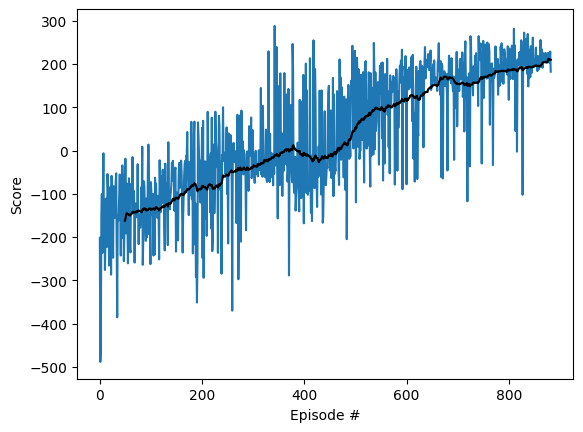

In [12]:
# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.plot(pd.Series(scores).rolling(50).mean(), color='black')
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

### Animate it with Video

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


The catalog `/video` should already be made, otherwise it won't work

In [ ]:
from IPython.display import Video, display

def show_video(file_path):
    """
    Display a video in Google Colab given the file path.

    :param file_path: Path to the video file
    """
    display(Video(file_path, embed=True))

def show_video_of_model(agent, env_name):
    env = gym.make(env_name)
    vid = video_recorder.VideoRecorder(env, path="/content/gdrive/MyDrive/video/{}.mp4".format(env_name))
    agent.qnetwork_local.load_state_dict(torch.load('checkpoint.pth'))
    state = env.reset()
    done = False
    while not done:
        frame = env.render(mode='rgb_array')
        vid.capture_frame()

        action = agent.act(state)

        state, reward, done, _ = env.step(action)
    env.close()

In [ ]:
agent = Agent(state_size=8, action_size=4, seed=0)
show_video_of_model(agent, 'LunarLander-v2')

/usr/local/lib/python3.11/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.11/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.11/dist-packages/gym/wrappers/monitoring/video_recorder.py:78: DeprecationWarning: WARN: Recording ability for environment LunarLander-v2 initialized with `render_mode=None` is marked as deprecated and will be removed in the future.
  logger.deprecation(
/usr/local/lib/python3.11/dist-packages/gym/wrappers/monitoring/video_recorder.py:101: DeprecationWarning: WARN: <class 

In [ ]:
show_video('/content/gdrive/MyDrive/video/LunarLander-v2.mp4')

### Experiments

In [13]:
BUFFER_SIZE = int(1e5)
BATCH_SIZE = 64
GAMMA = 0.98            # smaller discount factor
TAU = 1e-3
LR = 5e-4
UPDATE_EVERY = 1        # update network every step

Here you need to run again cells with Agent and ReplayBuffer classes

In [16]:
scores_var1 = dqn()

Episode 100	Average Score: -141.86
Episode 200	Average Score: -48.31
Episode 300	Average Score: 71.70
Episode 400	Average Score: 193.28
Episode 406	Average Score: 200.49
Environment solved in 306 episodes!	Average Score: 200.49


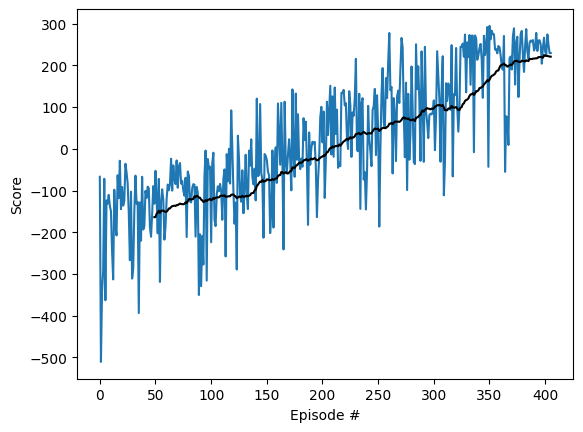

In [17]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores_var1)), scores_var1)
plt.plot(pd.Series(scores_var1).rolling(50).mean(), color='black')
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [18]:
BUFFER_SIZE = int(1e3) # smaller buffer size
BATCH_SIZE = 64
GAMMA = 0.99
TAU = 1e-3
LR = 1e-3              # higher learning rate
UPDATE_EVERY = 4

In [21]:
scores_var2 = dqn()

Episode 100	Average Score: -95.50
Episode 200	Average Score: -10.79
Episode 300	Average Score: 70.91
Episode 400	Average Score: 170.33
Episode 420	Average Score: 200.10
Environment solved in 320 episodes!	Average Score: 200.10


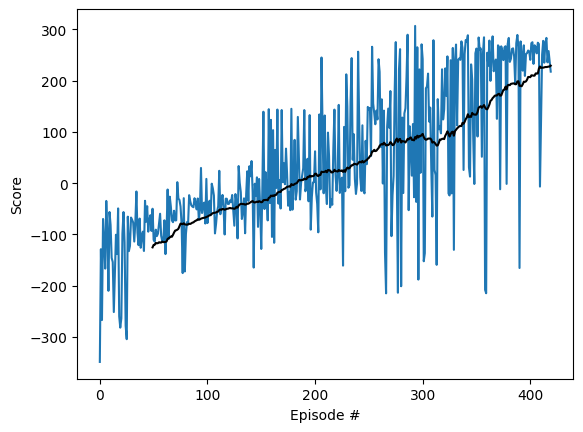

In [22]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores_var2)), scores_var2)
plt.plot(pd.Series(scores_var2).rolling(50).mean(), color='black')
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [23]:
BUFFER_SIZE = int(1e6)  # bigger buffer size
BATCH_SIZE = 32         # smaller batch size
GAMMA = 0.99
TAU = 1e-3
LR = 1e-5
UPDATE_EVERY = 2        # more frequent network update

In [26]:
scores_var3 = dqn()

Episode 100	Average Score: -93.89
Episode 200	Average Score: -10.96
Episode 300	Average Score: 80.04
Episode 395	Average Score: 201.50
Environment solved in 295 episodes!	Average Score: 201.50


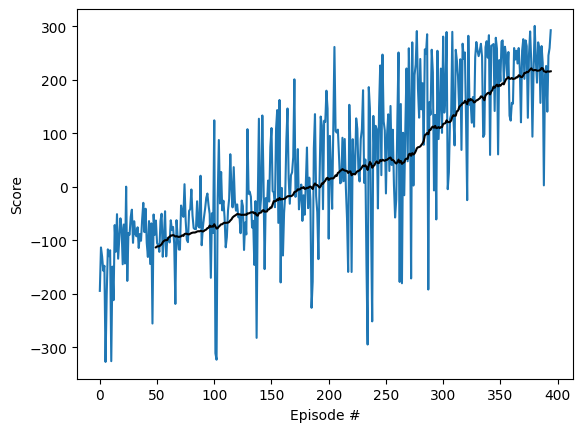

In [27]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores_var3)), scores_var3)
plt.plot(pd.Series(scores_var3).rolling(50).mean(), color='black')
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

### Based on the results, I have tried to select optimal parameters

In [31]:
BUFFER_SIZE = int(1e4)
BATCH_SIZE = 64
GAMMA = 0.99
TAU = 1e-3
LR = 1e-4
UPDATE_EVERY = 2

In [34]:
scores_var4 = dqn()

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Episode 100	Average Score: -107.84
Episode 200	Average Score: -33.55
Episode 300	Average Score: 80.17
Episode 400	Average Score: 201.37

Environment solved in 300 episodes!	Average Score: 201.37


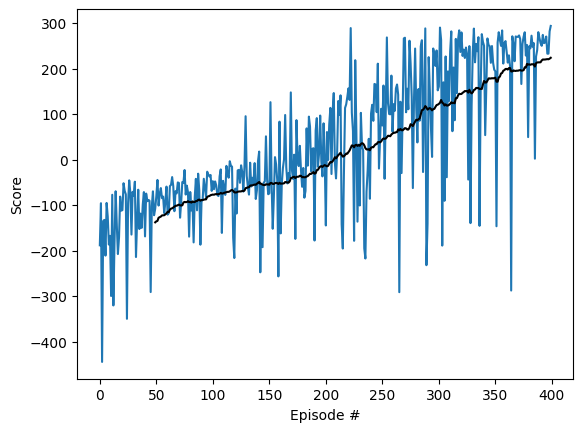

In [37]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores_var4)), scores_var4)
plt.plot(pd.Series(scores_var4).rolling(50).mean(), color='black')
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

### Comparison of all the variants and random actions

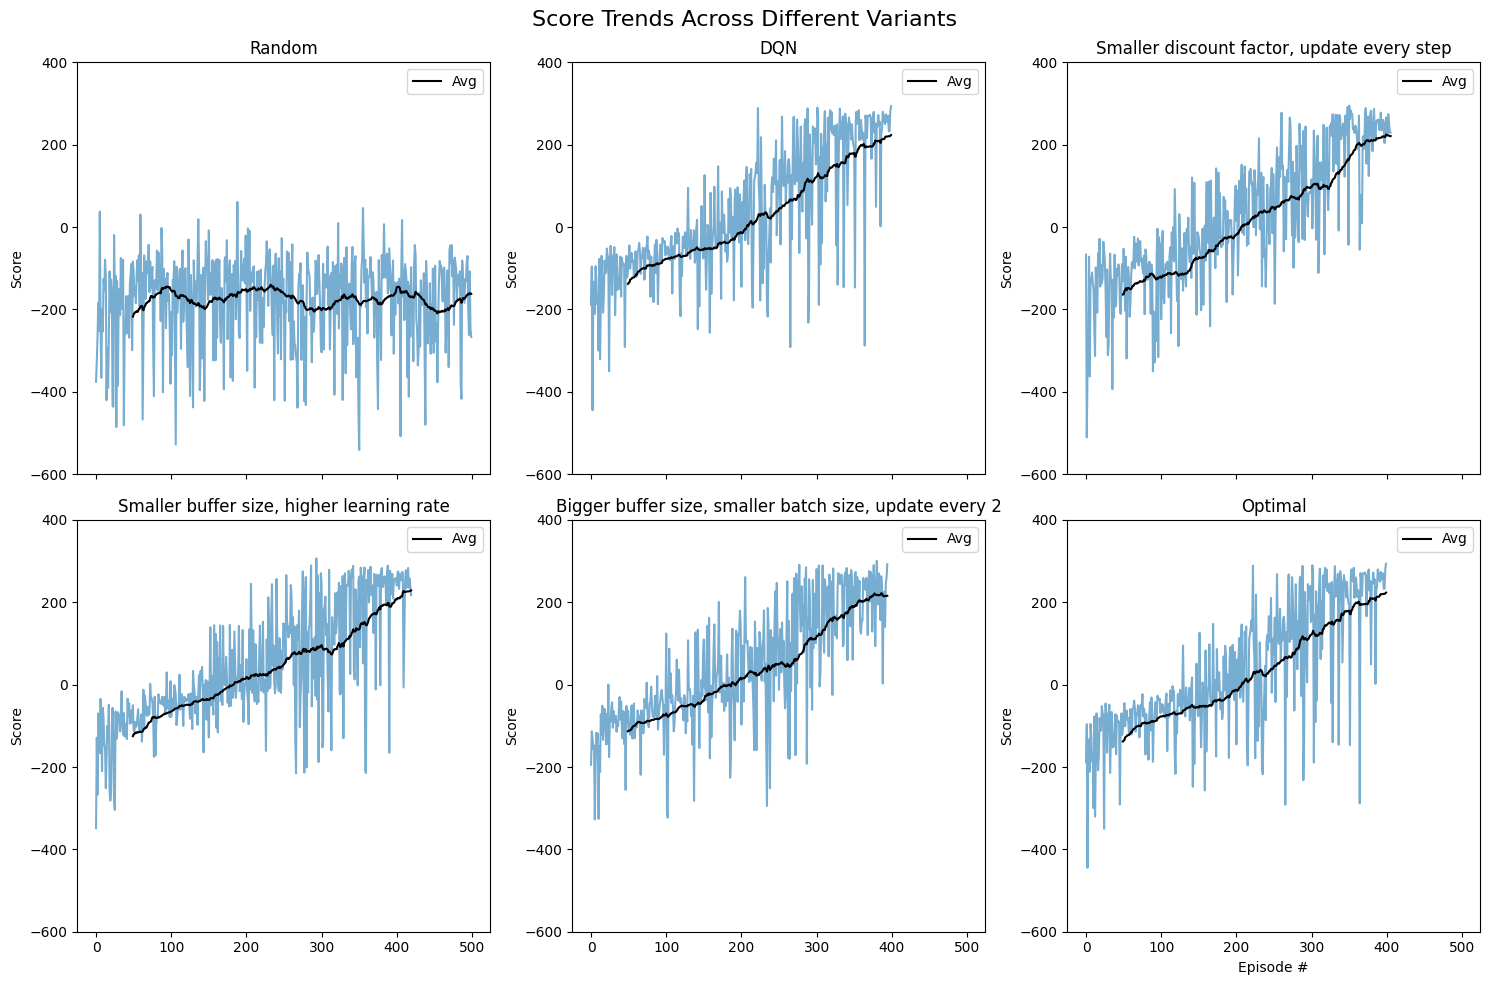

In [41]:
score_sets = {
    "Random": scores_random,
    "DQN": scores,
    "Smaller discount factor, update every step": scores_var1,
    "Smaller buffer size, higher learning rate": scores_var2,
    "Bigger buffer size, smaller batch size, update every 2": scores_var3,
    "Optimal": scores_var4
}

fig, axes = plt.subplots(2, 3, figsize=(15, 10), sharex=True)

# Flatten axes array for easier iteration
axes = axes.flatten()

for ax, (label, scores) in zip(axes, score_sets.items()):
    ax.plot(np.arange(len(scores)), scores, alpha=0.6)
    ax.plot(pd.Series(scores).rolling(50).mean(), color='black', label="Avg")
    ax.set_ylabel("Score")
    ax.set_ylim(-600, 400)
    ax.legend()
    ax.set_title(label)

fig.suptitle("Score Trends Across Different Variants", fontsize=16)
axes[-1].set_xlabel("Episode #")
plt.tight_layout()
plt.show()